In [2]:
import numpy as np
from scipy import linalg
import tensorly as tly
import matplotlib.pyplot as plt
# np.random.seed(1)

In [4]:
TENSOR_ORDER = 3
CORE_TENSOR_SHAPE = (3, 3, 3)
tensor = np.random.randint(0, 20, size=CORE_TENSOR_SHAPE)

### Important interpretation

---

Each entry of a numpy tensor is of the form $X_{IJK}$, but while printing the tensor, it does not print the tensor sheet ($k$) wise. Instead it prints in the indexing order. So the sheets you will see will be first row level sheets $i$ and then $j$ level and then $k$ level sheets.

In [10]:
#Testing operations 

X  = np.arange(24).reshape(3,4,2) # row, col, depth (your choice your interpretation)
print(X)
# print(tensor)
# print(X[2][2][1]) # k, i, j indexing according to the picure here
# print(X[...,1])
unfolded = tly.unfold(X, 0)
mode=0
unfolded_2=np.reshape(np.moveaxis(X, mode, 0),(X.shape[mode], -1), order='F') # mode 1 matricization of the tensor
print(unfolded)
print("\n",unfolded_2)
# print(X.reshape(-1, 3, order='F'))

[[[ 0  1]
  [ 2  3]
  [ 4  5]
  [ 6  7]]

 [[ 8  9]
  [10 11]
  [12 13]
  [14 15]]

 [[16 17]
  [18 19]
  [20 21]
  [22 23]]]
[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]]

 [[ 0  2  4  6  1  3  5  7]
 [ 8 10 12 14  9 11 13 15]
 [16 18 20 22 17 19 21 23]]


In [41]:
class CP:
    def __init__(self, tensor, rank, max_iter=10000, eps=0.01):
        """
        PARAFAC decompositon, it initializes the maximum amount of iterations that 
        are done along with the tolerance value for the convergence
        it also takes the size of the core tensor `rank`
        """
        #Original Tensor
        self.tensor = tensor

        #Rank of decomposition being targeted
        self.rank = rank
        
        #Max iterations
        self.max_iter = max_iter

        #Stopping error value
        self.eps = eps

        #Extra book keeping not really required
        self.prod_norms = []
        self.prod_kr_norms = []
        self.factor_update_norms = []
        self.core_norms = []

        #Stores the errrors at each step
        self.errors = []
        #Factor matrixes
        self.factors = []

        #Current lamda value
        self.core = np.zeros(CORE_TENSOR_SHAPE)

        #Initally take all lamda's as 1
        np.fill_diagonal(self.core, 1)
         
    def fit(self):
        #training loop,self explanatory
        self._init_factors()
        for i in range(self.max_iter):
            for mode in (range(TENSOR_ORDER)):
                self._update_factors(mode)
            if self._is_converged():
                break
        print("Converged in {} iterations".format(i))
        print("Final error = ", self.errors[-1])
    
    def _size_check(self, mode):
        print("------------------------- Mode {} -------------------------".format(mode))
        print ("Size of the tensor = ", self.tensor.shape)
        print ("Size of the core tensor = ", self.core.shape)
        print ("Size of factor mode = ", self.factors[mode].shape)
        print ("Size of the unfolded tensor = ", tly.unfold(self.tensor, mode).shape)
        print ("Size of the Khatri-Rao product = ", linalg.khatri_rao(self.factors[0], self.factors[1]).shape)
    
    def _init_factors(self):
        """
        initialize the factors using the `rank` many left singular 
        vectors of the corresponding mode-n matricization of the input tensor
        """
        #gets all the n mode matricizations of tensor
        matricized = [np.reshape(np.moveaxis(self.tensor, mode, 0),(self.tensor.shape[mode], -1), order='F') for mode in range(TENSOR_ORDER)]

        #Uses SVD to initalize factor matrix A(n) of dim=I_n x R as first R columns of SVD decomposition of 
        # Tensors nth mode matricization
        self.factors = [linalg.svd(matrix, full_matrices=False)[0][:, :self.rank] for matrix in matricized]
        # for x in self.factors:
        #     print(np.linalg.norm(x, axis=0))
        print("Initialized factors")
        pass
    
    def _update_factors(self, mode):
        """
        Update the factors per iteration for the `mode`'th Factor
        """
        # compute hadamard product of the gram matrices of other factors
        prod = np.ones((self.rank, self.rank))
        for pos in reversed(range(TENSOR_ORDER)):
            if(mode != pos):
                prod = np.multiply(prod, self.factors[pos].T @ self.factors[pos])
        self.prod_norms.append(np.linalg.norm(prod))

        # compute the Khatri-Rao product of the other factors
        prod_kr = np.ones((1, self.rank))
        for pos in reversed(range(TENSOR_ORDER)):
            if(mode != pos):
                prod_kr = linalg.khatri_rao(prod_kr, self.factors[pos])
        
        self.prod_kr_norms.append(np.linalg.norm(prod_kr))
        
        W = np.reshape(np.moveaxis(self.tensor, mode, 0),(self.tensor.shape[mode], -1), order='F') @ prod_kr
        
        # now solve the least squares problem
        self.factors[mode] = W @ np.linalg.pinv(prod)
        # now normalize the factor and update the core tensor
        col_norms = np.linalg.norm(self.factors[mode], axis=0)

        # print(self.factors[mode])
        # print(col_norms)
        self.factors[mode] = self.factors[mode] / col_norms # normalize the self.factors[mode]
        # print(self.factors[mode])
        self.factor_update_norms.append(np.linalg.norm(self.factors[mode]))
        # print(col_norms)

        #Find new lamda values
        norm_identity = np.zeros(CORE_TENSOR_SHAPE)
        np.fill_diagonal(norm_identity,col_norms)
        # print(norm_identity)
        self.core = norm_identity
        self.core_norms.append(np.linalg.norm(self.core))
        # self._size_check(mode)
        pass
    
    def _is_converged(self):
        """
        check if the algorithm has converged
        by computing the Frobenius norm of the difference between the current tensor
        and the tensor obtained by multiplying the factors
        """
        # intitialize the core identitiy tensor
        

        # print(core)
        estim = tly.tenalg.multi_mode_dot(self.core, self.factors)
        error = np.linalg.norm(self.tensor - estim)
        print("Error = ", error)
        self.errors.append(error)
        return error < self.eps
    
    def plot_errors(self):
        plt.plot(self.errors)
        # plt.plot(self.prod_norms)
        # plt.plot(self.prod_kr_norms)
        # plt.plot(self.factor_update_norms)
        # plt.plot(self.core_norms)
        plt.legend(["Errors"])
        plt.xlabel("Iterations")
        plt.ylabel("Frobenius norm")
        plt.show()
        
        
        

In [42]:

factors = tly.decomposition.parafac(tensor, rank=3)

In [43]:
identity = np.zeros(CORE_TENSOR_SHAPE)
np.fill_diagonal(identity, factors[0])
estim_tensorly = tly.tenalg.multi_mode_dot(identity, factors[1])
print(np.linalg.norm(tensor - estim_tensorly))

9.36465882030164


In [44]:
decomp = CP(tensor, rank=3)
decomp.fit()

Initialized factors
Error =  13.254644489261015
Error =  11.150399573774834
Error =  10.445618661038898
Error =  10.176845731804317
Error =  10.027240983584996
Error =  9.924817068469894
Error =  9.848542385667077
Error =  9.789166242964496
Error =  9.74158462217358
Error =  9.702610997304896
Error =  9.670108378024876
Error =  9.642582261328462
Error =  9.618959288516384
Error =  9.598453320203532
Error =  9.580478828977526
Error =  9.564592674481933
Error =  9.55045405224024
Error =  9.537796546414093
Error =  9.526408437221644
Error =  9.516118720114013
Error =  9.506787113019106
Error =  9.498296864285502
Error =  9.490549535303344
Error =  9.48346117983737
Error =  9.476959514411659
Error =  9.47098179459853
Error =  9.465473196649834
Error =  9.460385563352531
Error =  9.455676414754354
Error =  9.451308153714887
Error =  9.447247416773772
Error =  9.443464535193144
Error =  9.43993308106684
Error =  9.43662948039393
Error =  9.43353267990569
Error =  9.430623857857139
Error =  9

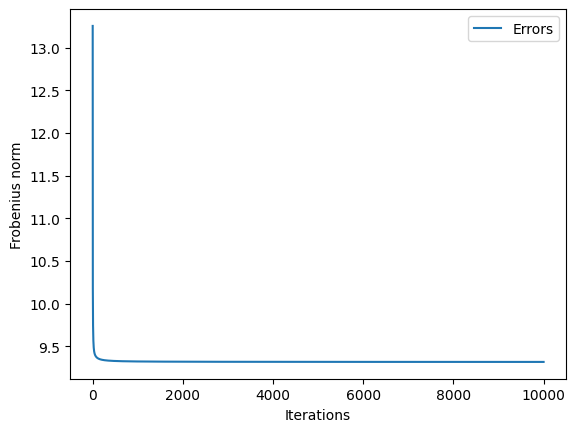

In [45]:
decomp.plot_errors()

In [46]:
decomp.core

array([[[ 41.667533  ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        ],
        [  0.        , 255.83399227,   0.        ],
        [  0.        ,   0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        , 255.07722426]]])

In [47]:
decomp.factors

[array([[ 0.89939556, -0.38003282,  0.42865805],
        [ 0.32999397,  0.22109795, -0.21802384],
        [ 0.28669079,  0.89815964, -0.87676558]]),
 array([[-0.51422391,  0.16428311, -0.16651937],
        [-0.58986543, -0.98574726,  0.98061227],
        [-0.62260143, -0.03624098,  0.10329992]]),
 array([[-0.75957379,  0.50566599, -0.50973394],
        [-0.47031687,  0.77986016, -0.8040291 ],
        [-0.44927686, -0.3689445 ,  0.30611848]])]

In [48]:
factors[0]

array([1., 1., 1.])

In [49]:
factors[1]

[array([[33.98834135, -4.72997363,  6.19102326],
        [12.2921231 ,  4.59937953, -1.77821339],
        [10.52123034, 19.45624122, -7.60860157]]),
 array([[ 0.51467491, -0.19038318,  0.34527333],
        [ 0.60544142,  1.32620298, -2.11859844],
        [ 0.65395272, -0.23124852, -0.80980554]]),
 array([[ 0.83292671, -0.58994107,  0.77722656],
        [ 0.53550088, -0.83404867,  1.31768367],
        [ 0.49350659,  0.72687167, -0.14250942]])]